In [7]:
# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Reading the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib as pl
import os
import copy
import matplotlib.pyplot as plt
from matplotlib import gridspec


### Reading the Data
Source of csv file: https://thinkingneuron.com/concrete-strength-prediction-case-study-in-python/

In [9]:
#cement_df=pd.read_csv('C:/Users/santa/Documents/AI/ConcreteStrengthData.csv')

path_csv = pl.Path(os.getcwd()) / f'ConcreteStrengthData.csv'
with open(path_csv, 'rb') as file:
    cement_df = pd.read_csv(file)

# Removing duplicate rows if any
cement_df=cement_df.drop_duplicates()
print('Shape psot deletion of duplicate values:', cement_df.shape)

cement_df.head(10)

Shape psot deletion of duplicate values: (1005, 9)


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29


In [10]:
#High Level Summary of Data
cement_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1005 non-null   float64
 1   BlastFurnaceSlag           1005 non-null   float64
 2   FlyAshComponent            1005 non-null   float64
 3   WaterComponent             1005 non-null   float64
 4   SuperplasticizerComponent  1005 non-null   float64
 5   CoarseAggregateComponent   1005 non-null   float64
 6   FineAggregateComponent     1005 non-null   float64
 7   AgeInDays                  1005 non-null   int64  
 8   Strength                   1005 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 78.5 KB


In [11]:
# Finding how many missing values are there for each column
cement_df.isnull().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

### Initial Observations:
- The target variable is Strength and is of data type float64 and is a continuous variable
- There are no missing values

In [12]:
for column_name in cement_df.columns:
    column = cement_df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

Count of zeros in column  CementComponent   is :  0
Count of zeros in column  BlastFurnaceSlag  is :  470
Count of zeros in column  FlyAshComponent  is :  541
Count of zeros in column  WaterComponent  is :  0
Count of zeros in column  SuperplasticizerComponent  is :  378
Count of zeros in column  CoarseAggregateComponent  is :  0
Count of zeros in column  FineAggregateComponent  is :  0
Count of zeros in column  AgeInDays  is :  0
Count of zeros in column  Strength  is :  0


In [13]:
cement_df.columns=["CementComponent","BlastFurnaceSlag","FlyAshComponent","WaterComponent",
                "SuperplasticizerComponent","CoarseAggregateComponent","FineAggregateComponent","AgeInDays","Strength"]
cement_df.shape

(1005, 9)

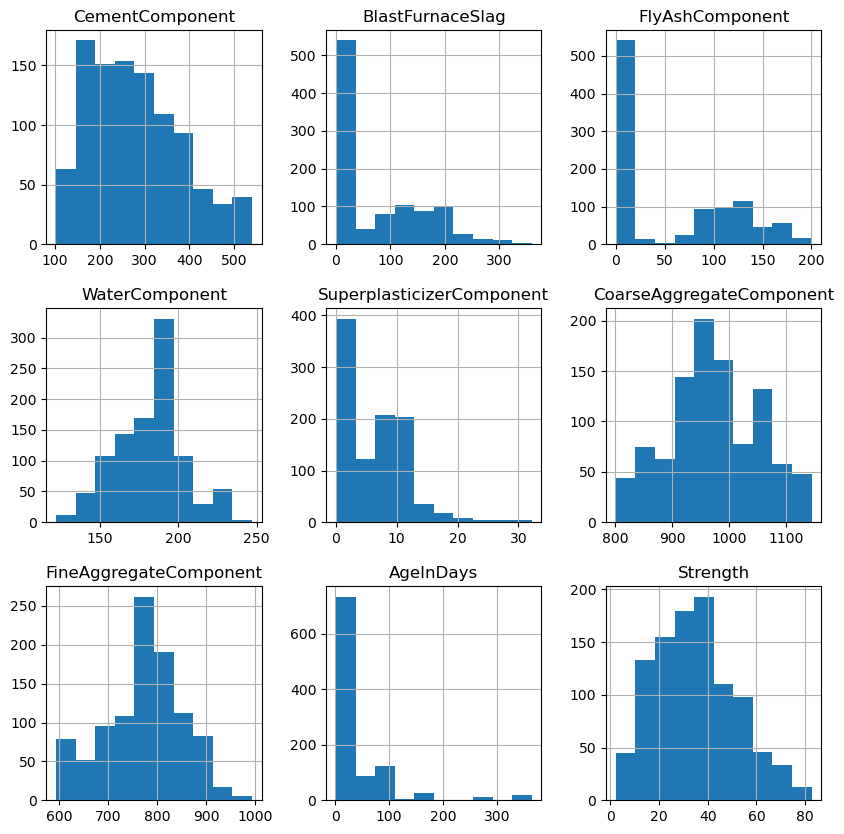

In [14]:
cement_df.hist(figsize=(10,10))
plt.show()

### Histogram Plot Observations:
- Compressive strength (bottom-right)seems to be normally distributed with slight skew to the left. Looking at the near bell curve distribution of Target variable is desirable when performing Regression. There are sufficient number of rows for each type of values to learn from. 
- Slag, Ash and Superplasticizer have many data points with zero value. Slag:470, ash:541 and Superplasticizer:378
- Looking at age, it indicates that most cements are aged 100 days and below

### Further Analysis:
To understand the impact of zero values of Slag, Ash and Superplasticizer on Strength, three separate datasets were created by removing rows having zero values for each of the attribute. Below is the summary statistics and histogram plot of 'Strength' of each dataset and compared with original data.

In [15]:
cement_df_noSlag = cement_df.loc[cement_df["BlastFurnaceSlag"] > 0 ]
cement_df_noAsh = cement_df.loc[cement_df["FlyAshComponent"] > 0 ]
cement_df_noSPC = cement_df.loc[cement_df["SuperplasticizerComponent"] > 0 ]
#cement_df_noZeros = cement_df.loc[(cement_df["SuperplasticizerComponent"] > 0) & (cement_df["FlyAshComponent"] > 0) & (cement_df["BlastFurnaceSlag"] > 0)]

In [16]:
cement_df['Strength'].describe()

count    1005.000000
mean       35.250378
std        16.284815
min         2.330000
25%        23.520000
50%        33.800000
75%        44.870000
max        82.600000
Name: Strength, dtype: float64

In [17]:
cement_df_noSlag['Strength'].describe()

count    535.000000
mean      38.435439
std       16.906314
min        2.330000
25%       26.230000
50%       37.810000
75%       50.495000
max       82.600000
Name: Strength, dtype: float64

In [18]:
cement_df_noAsh['Strength'].describe()

count    464.000000
mean      34.654461
std       14.234035
min        7.320000
25%       24.212500
50%       33.745000
75%       44.280000
max       76.240000
Name: Strength, dtype: float64

In [19]:
cement_df_noSPC['Strength'].describe()

count    627.000000
mean      38.690893
std       16.221685
min        7.320000
25%       26.270000
50%       37.400000
75%       49.935000
max       82.600000
Name: Strength, dtype: float64

<Axes: title={'center': 'Strength: All Data Vs Slag (non-zero)'}, ylabel='Frequency'>

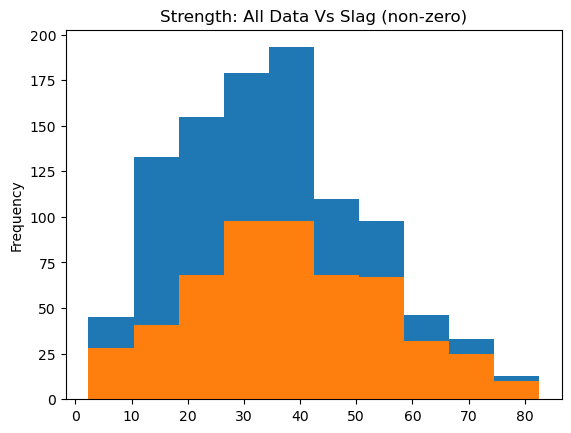

In [20]:
cement_df['Strength'].hist()
cement_df_noSlag['Strength'].plot(kind='hist', title='Strength: All Data Vs Slag (non-zero)',xlabel='Strength-Mpa',ylabel='Frequency')

<Axes: title={'center': 'Strength: All Data Vs Ash (non-zero)'}, ylabel='Frequency'>

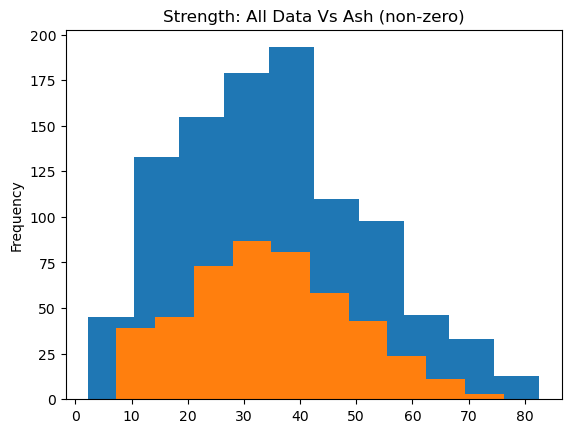

In [21]:
cement_df['Strength'].hist()
cement_df_noAsh['Strength'].plot(kind='hist', title='Strength: All Data Vs Ash (non-zero)',xlabel='Strength-Mpa',ylabel='Frequency')

<Axes: title={'center': 'Strength: All Data Vs SuperplasticizerComponent (non-zero)'}, ylabel='Frequency'>

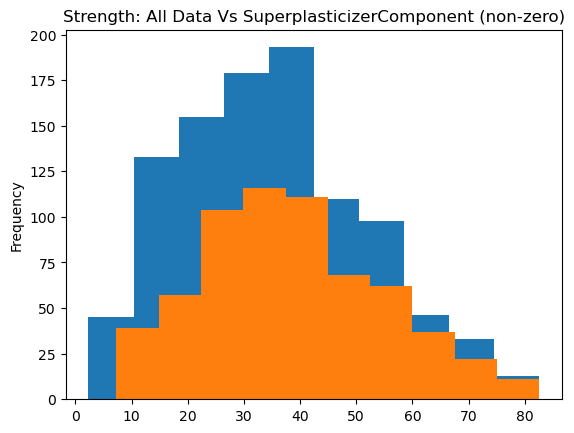

In [22]:
cement_df['Strength'].hist()
cement_df_noSPC['Strength'].plot(kind='hist', title='Strength: All Data Vs SuperplasticizerComponent (non-zero)',xlabel='Strength-Mpa',ylabel='Frequency')

### Summary of Further Anlaysis:
- If Ash values are zero then the mean Strenght is slightly lower (34 Mpa versus 38 Mpa). The max-value of strength is also reduced.
- Absence of Ash OR SuperplasticizerComponent doesn't lower the cement strength below 7 Mpa.
- Generally the spread of data of individal subsets of original data is similar. This suggests that the zero values of these three components(inputs) is relevant and can't be ignored for creating predictive models. 

### Cross-correlation Anlysis:

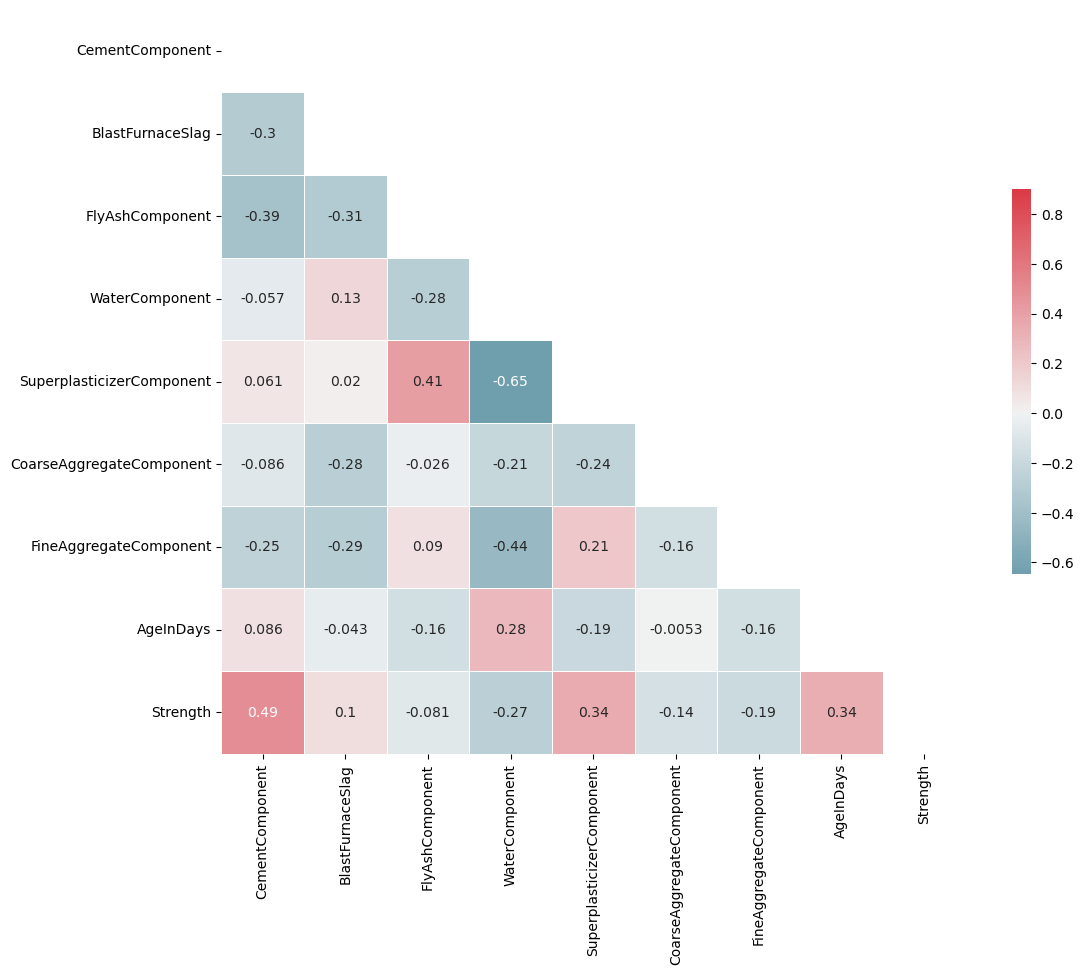

In [23]:
corr = cement_df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, annot=True,cbar_kws={"shrink": .5})
plt.show()

### Cross-correlation Chart Observations:
- Compressive strength has weak correlation (<0.5) with all the features/inputs.
- Slag and Ash correlate very weakly with Compressive Strength but these shouldn't be excluded from analysis. Because Slag has good correlation with superplasticiser and slag has weak negative corealtion with fine and coarse aggregates.
- Decision was taken to not drop any of the input features from analysis.